# ABACUS+DPMD+Dflow计算半导体熔点性质



## 参赛队伍成员信息
- 队伍成员：张星辰	 	 
- 学校/企业：北京大学工学院	 	 
- 联系方式： 18800131821	 	 
- 命题选择（自由/固定）：自由命题
- 主题：ABACUS使用训练好的DP势进行DPMD模拟计算半导体熔点性质

# 一、介绍

### ABACUS分子动力学介绍
ABACUS 的分子动力学功能：支持第一性原理分子动力学 FPMD 方法，也支持经典的 Lennard-Jones（LJ 对势）的分子动力学模拟。此外，ABACUS 还支持深度势能分子动力学（Deep Potential Molecular Dynamics，简称 DPMD）方法，此时需要编译 [DeePMD-kit](https://github.com/deepmodeling/deepmd-kit) 软件包并在编译原子算筹软件时进行动态库的链接。

经过测试，使用镜像registry.dp.tech/dptech/prod-12058/abacus-deepmd-kit-candela:abacus-deepmd-kit-candela_v1.01可以直接命令行运行本教程的任务。

读者若采用下面提供的dflow脚本来提交任务，则无须在本地安装ABACUS并编译接口，也无需安装并编译Candela，只需准备ABACUS输入文件即可。

### 熔点测试方法介绍
#### 直接加热法
- 通过加热材料来观察其熔化过程。在模拟开始时，系统中的原子或分子被放置在初始温度下，并通过应用热量来逐渐升高温度。随着温度的升高，原子或分子之间的相互作用会发生变化，直到达到熔点。通过监测系统中原子或分子的位置、能量以及其他物理性质的变化，可以确定材料的熔点。

- 本教程使用的是改进的直接加热法，由于传统的直接一个任务设置初末温度不同，会导致过程中的每一个点都是非平衡态，无法准确说明该温度下的物态，故改为采用在每个温度用NPT系综来模拟几十ps使体系达到该温度下的平衡态，输出均方差位移和扩散系数确定物态。但这种方法不用dflow的话需要多次手动修改参数提交任务，较为烦琐。提供的dflow脚本可以实现相对自动化的过程。
#### 两相法
- 通过观察固态和液态之间的相互转化过程。在模拟开始时，系统中的原子或分子被放置在低温下并形成固态结构。然后，通过逐渐升高温度，原子或分子之间的相互作用发生变化，导致材料从固态向液态转化。通过监测系统中原子或分子结构、密度、能量等物理性质的变化，可以确定材料的熔点
#### Z-method
- Z方法是一种用于分子动力学模拟的热分析技术，结合了直接加热法和两相法的优点。该方法使用两个相对移动的传感器，即一个加热和一个冷却传感器，来控制系统的温度。通过在加热和冷却之间交替改变温度，并监测原子或分子的位置、能量等性质的变化，可以确定材料的熔点。

# 二、准备

# 算例下载地址

In [ ]:
git clone https://github.com/xinchenniny/ABACUS-dflow.git

## 准备输入文件INPUT

示例体系采用立方 ZnS，实验熔点为 1350 ℃ 。我们在这里选取较为简单的直接加热法，先前的LAMMPS模拟采用216原子体系的结果测得ZnS的熔点为1967~2009K，实验熔点是1623K，偏高约370K。

我们可以修改md_tfirst的参数，在各个温度下跑合适的MD步数（用md_nstep设置，此处为经验值），得到该温度下的平衡态结构。未知熔点时，可等间距选取温度点进行测试，确定熔点所在区间后在此区间内插入等间距的点，进一步缩小熔点测试结果范围，注意初始温度的设置不要超过DPGEN采样温度的上限。

以下为示例文件

In [ ]:
INPUT_PARAMETERS
suffix              DPMD-melting
calculation         md
esolver_type        dp
pot_file            ./frozen_model.pb
md_nstep            25000
md_dt               2
md_type             npt
md_tfirst           2500
md_tchain           3
md_tfreq            0.005
md_seed             2121491
md_pmode            iso
md_pcouple          xyz
md_pfirst           0.001
md_pfreq            0.0005
md_pchain           3
md_dumpfreq         1
md_restartfreq      1000
init_vel            0
dump_force          1
dump_vel            1
dump_virial         1

这些参数在 ABACUS 线上文档中均有说明，在这里再进行简单概述：

- calculation：设置 ABACUS 计算类型，做分子动力学模拟请设置为 md。
- esolver_type：给定原子位置进行系统能量的计算，默认 Kohn-Sham 密度泛函理论（ksdft），还可以设置 LJ 势（lj）或者深度势能（dp）。理论上来说，所有的 esolver_type 都可以用于 MD 计算。
- pot_file：势函数文件路径。
- md_nstep：MD 模拟的总步数。 
- md_type：MD 算法种类，默认是正则系统 nvt，这里的例子选择的是 npt，即 NVE 微正则系综。
- md_dt：MD 计算每一步的时间步长（单位是 fs），与 md_nstep 共同决定 MD 总时长。
- md_tfirst：MD 系统的初始温度（单位是 K）。
- md_tchain：ABACUS默认值为1，LAMMPS默认值为3。
- md_tfreq: 控制MD模拟中温度变化的快慢，推荐值为1/40/dt。与LAMMPS中Tdamp的关系：为1/(1000*Tdamp)fs-1
- md_seed：初始速度是否随机。
- md_pfirst：MD 系统的初始压强（单位是 kbar）。
- md_pfreq: 控制MD模拟中压力变化的快慢，推荐值为1/400/dt。与LAMMPS中Pdamp的关系：为1/(1000*Pdamp)fs-1
- md_pchain：ABACUS默认值为1，LAMMPS默认值为3。
- md_pmode: MD模拟中压强施加的方式。
- md_pcouple: 控制MD模拟中盒子缩放方向的独立性。
- md_dumpfreq：MD 输出文件 MD_dump 中原子以及晶胞信息的输出频率
- md_restartfreq：结构文件 STRU_MD_${istep} 的输出频率，MD 续算文件 Restart_md.dat 的更新频率

注：文献的结果一般熔化在10ps以内，所以这里md_nstep取得太大没有什么意义

## 准备原子体系的结构文件 STRU

本步骤所需的描述原子结构的文件有：

    *.cif

可以从多个渠道下载所系的结构文件，本案例主要从 materials project 网站下载 cif 文件，使用的半导体可能对应多个原子构型。先前的LAMMPS模拟表明初始构型的选取对结果的影响不大，因为最终是这个温度下该体系的平衡结构存在。采用哪些构型取决于用户所研究的体系和性质，一般可选取所关心的物质温度和压强区间内可能出现的结构，也可以采用最简单的立方结构。本案例主要用立方ZnS来演示。


考虑到尺寸效应，可以先用 VESTA 把 cif 文件中的晶格扩大成想要的大小。

得到了 cif 之后，可以使用下列方法把 cif 转换成 STRU 文件：

In [ ]:
git clone https://gitlab.com/1041176461/ase-abacus.git
cd ase-abacus
python3 setup.py install

cif转STRU

In [ ]:
from ase.io import read, write
from pathlib import Path

cs_dir = './'
cs_vasp = Path(cs_dir, 'ZnS.cif') # 修改为自己的cif文件名
cs_atoms = read(cs_vasp, format='cif')
cs_stru = Path(cs_dir, 'STRU')
write(cs_stru, cs_atoms, format='abacus')

运行上述 python 脚本，把 cif 转成 ABACUS 所需的 STRU 文件。

注：可以通过如下命令确定 DP 势文件中是否存在关键字“type_map”

In [ ]:
$ strings frozen_model.pb | grep type_map

":{"type":"exp","start_lr":0.001,"stop_lr":3.5e-08,"decay_steps":40000,"scale_by_worker":"linear"},"loss":{"start_pref_e":0.2,"limit_pref_e":1,"start_pref_f":1000,"limit_pref_f":1,"start_pref_v":0.01,"limit_pref_v":1.0,"type":"ener","start_pref_ae":0.0,"limit_pref_ae":0.0,"start_pref_pf":0.0,"limit_pref_pf":0.0,"enable_atom_ener_coeff":false},"training":{"disp_file":"lcurve.out","disp_freq":100,"save_freq":1000,"save_ckpt":"model.ckpt","disp_training":true,"time_training":true,"profiling":false,"profiling_file":"timeline.json","training_data":{"systems":["./collect_data/init.000","./collect_data/sys.Zn32S32"],"batch_size":[1,1],"set_prefix":"set","auto_prob":"prob_sys_size","sys_probs":null},"seed":30112167820,"numb_steps":8000000,"validation_data":null,"enable_profiler":false,"tensorboard":false,"tensorboard_log_dir":"log","tensorboard_freq":1}}

如果存在关键字 type_map，那么 ABACUS 会自动匹配 STRU 和 DP 势文件中的原子种类顺序。

否则，STRU 中的原子种类以及顺序必须与 DP 势文件中的原子种类以及顺序一致。

## 准备DP势函数文件 frozen_model.pb

本案例中选取的DP势函数来源于ABACUS+DPGEN。读者若对势函数的生成方式感兴趣可以参考ABACUS中文文档教程

## Candela的准备

### 介绍
Candela 全称 Collection of ANalysis DEsigned for Large-scale Atomic simulations，目前支持分析 QE、ABACUS、LAMMPS 和 VASP 的分子动力学轨迹，Github 主页：https://github.com/MCresearch/Candela

更多ABACUS+Candela的使用可以参考https://mcresearch.gitee.io/abacus-user-guide/abacus-candela.html

我们用Candela来完成后处理工作。

### 运行环境准备

dflow脚本中提供的镜像registry.dp.tech/dptech/prod-12058/abacus-deepmd-kit-candela:abacus-deepmd-kit-candela_v1.00已安装好Candela，直接命令行输入candela即可运行。

若运行环境没有没有安装Candela,需要手动安装。步骤如下：

In [ ]:
git clone https://github.com/MCresearch/Candela.git
cd Candela
make CXX=g++ TEST=ON

此时Candela编译完成，可以运行串行版本，对一般体系计算MSD已经足够。

准备好输入文件和MD_dump文件后，进入输入文件所在路径，直接运行可以得到输出结果。

In [ ]:
candela

注：

若使用 Intel Oneapi 编译器，按照上述流程操作，在编译完成后即可在 bin 目录下看到 candela 可执行文件

若使用其他编译器，需要按照 Candela 目录下 Makefile.vars 修改相应的 CXX

In [ ]:
make -j4 #使用intel oneapi编译器

### 输入文件准备

示例INPUT文件如下：

注意此处msd_dt的单位为ps，需要修改为与ABACUS的INPUT文件中的md_dt一致。

In [ ]:
calculation  msd # Pair Distribution Function.
system ZnS
geo_in_type  ABACUS
geo_directory MD_dump
geo_1        1
geo_2        2000
geo_interval 1
geo_ignore   300

ntype        2        # number of different types of atoms.
natom        216   # total number of atoms.
natom1       108   #Zn
natom2       108   #S
id1          Zn
id2          S
msd_dt       0.002

# 三、Dflow的搭建及运行

## 流程图
整个流程为输入文件准备-[修改md_tfisrt-提交任务-candela后处理得到MSD]  

我认为把框内的部分并行执行，用dflow实现是灵活度最高的办法，这里用slices来做

改进后的流程如图：
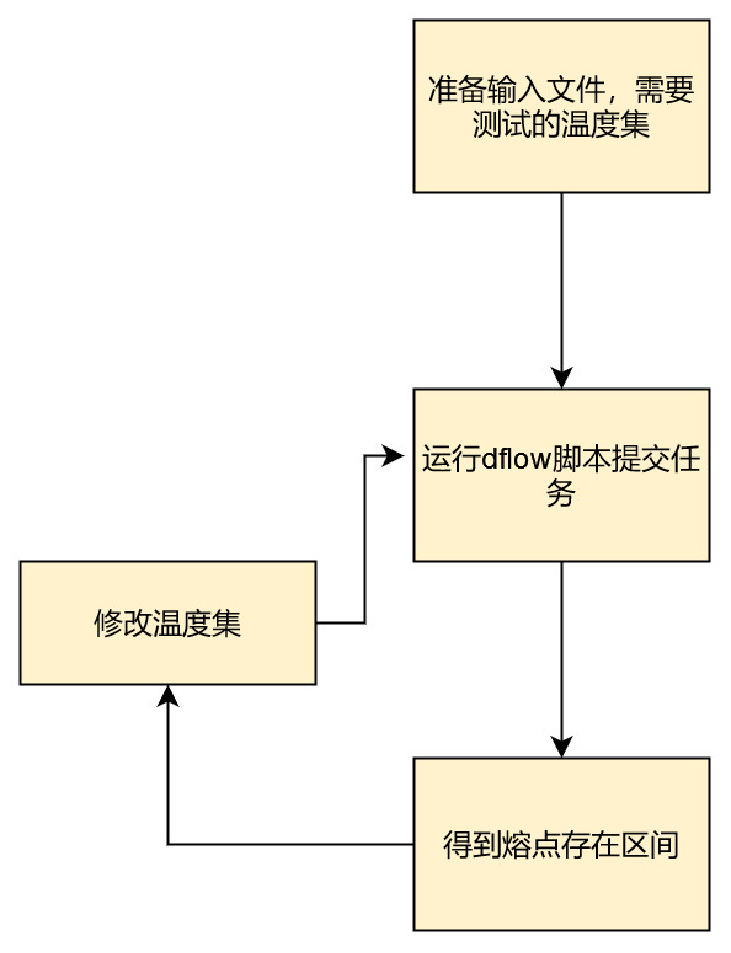

## Dflow代码
注：需要手动修改要跑的在不同温度下的温度个数NUM。输入文件为打包好的ABACUS输入文件夹（这里命名为DPMD）以及md_tfirst_file,该脚本放在同一目录下执行即可。

In [ ]:
NUM = 4 #计算温度值的数量
import getpass
from dflow import config, s3_config
from dflow.plugins import bohrium
from dflow.plugins.bohrium import TiefblueClient
config["host"] = "https://workflows.deepmodeling.com"
config["k8s_api_server"] = "https://workflows.deepmodeling.com"
bohrium.config["username"] = "2000011003@stu.pku.edu.cn"
bohrium.config["password"] = "Kepler08051005@"
bohrium.config["project_id"] = 15069
s3_config["repo_key"] = "oss-bohrium"
s3_config["storage_client"] = TiefblueClient()
from dflow.plugins.dispatcher import DispatcherExecutor

dispatcher_executor = DispatcherExecutor(
        machine_dict={
            "batch_type": "Bohrium",
            "context_type": "Bohrium",
            "remote_profile": {
                "input_data": {
                    "job_type": "container",
                    "platform": "ali",
                    "scass_type" : "c32_m128_4 * NVIDIA V100"
                },
            },
        },
    )

from typing import List
from dflow import Step, Workflow
from dflow.python import OP, OPIO, Artifact, OPIOSign, PythonOPTemplate, Slices
from dflow.utils import upload_artifact, download_artifact
import os
from pathlib import Path
import subprocess
import shutil
import numpy as np


class DPMD(OP):
    def __init__(self):
        pass
         
    @classmethod
    def get_input_sign(cls):
        return OPIOSign({
            "ABACUS_INPUT": Artifact(Path), #一系列输入文件
            "md_tfirst_file":Artifact(Path), #温度文件路径
            "index": int
        })

    @classmethod
    def get_output_sign(cls):
        return OPIOSign({
            "ABACUS_output_folder": Artifact(Path),  #OUT.suffix的路径
            "diffusion_coefficient": Artifact(Path)  
        })

    @OP.exec_sign_check
    def execute(
            self,
            op_in: OPIO,
    ) -> OPIO:
        cwd = os.getcwd()
        '''
        # Get the directory path of the "md_tfirst_file"
        md_tfirst_file_dir = os.path.dirname(op_in["md_tfirst_file"])

        # Change the current working directory to the directory containing the "md_tfirst_file"
        os.chdir(md_tfirst_file_dir)
        '''
        md_tfirst_file_path = os.path.join(op_in["md_tfirst_file"])
        index = op_in["index"]
        # Read the new value from the "md_tfirst_file"
        with open(md_tfirst_file_path, "r") as f:
           line = f.readline().strip()  # Read the first line and strip whitespace characters
           values = line.split()  # Split the line into a list of values
           new_md_tfirst = values[index]  # Get the second value (index 1)
        
        os.chdir(op_in["ABACUS_INPUT"] )
        # 进入 ABACUS_INPUT 文件夹下的 INPUT 文件
        input_file_path = os.path.join(op_in["ABACUS_INPUT"], "INPUT")
    
        # 打开 INPUT 文件并读取内容
        with open(input_file_path, "r") as f:
         content = f.read()

       # 寻找 md_tfirst 参数所在的行
        lines = content.splitlines()
        for i, line in enumerate(lines):
            if "md_tfirst" in line:
                # 拆分行为参数名和参数值
                parts = line.split()
                param_name = parts[0]
                old_value = parts[1]

                # 将参数值替换为新值
                new_value = new_md_tfirst  # 设置新的 md_tfirst 值
                parts[1] = new_value

                # 将修改后的行重新组合成字符串
                new_line = " ".join(parts)
                
                # 将新行替换回原始内容
                lines[i] = new_line
                break
    
        # 更新文件内容
        new_content = "\n".join(lines)
    
        # 保存修改后的文件内容
        with open(input_file_path, "w") as f:
             f.write(new_content)
    
        # 执行计算任务
        cmd =  "abacus" 
        subprocess.call(cmd, shell=True)
        os.chdir("./OUT.DPMD-melting")
        
        # 创建名为myCandela的新文件夹
        new_folder = "myCandela"
        if not os.path.exists(new_folder):
            os.mkdir(new_folder)

        # 复制MD_dump文件到myCandela文件夹中
        old_file = "MD_dump"
        new_path = os.path.join(new_folder, old_file)
        shutil.copy2(old_file, new_path)
        os.chdir(new_folder)
        # 执行计算任务
        cmd =  "tree" 
        subprocess.call(cmd, shell=True)

        #准备Candela输入文件
        content = '''
        calculation  msd # Pair Distribution Function.
        system ZnS
        geo_in_type  ABACUS
        geo_directory MD_dump
        geo_1        1
        geo_2        25000
        geo_interval 1
        geo_ignore   0

        ntype        2        # number of different types of atoms.
        natom        216   # total number of atoms.
        natom1       108   #Zn
        natom2       108   #S
        id1          Zn
        id2          S
        msd_dt       0.002
        '''
        with open("INPUT", "w") as file:
            file.write(content)

        # 执行计算任务
        cmd =  "candela" 
        subprocess.call(cmd, shell=True)

        # 读取MSD.dat文件
        data = np.loadtxt('MSD.dat')

        # 提取时间和平均方位移数据
        time = data[:, 0]
        msd = data[:, 2]

        # 计算扩散系数
        slope, intercept = np.polyfit(time, msd, 1)
        diffusion_coefficient = slope / 2

        # 将扩散系数写入文件
        filename = str(new_md_tfirst)+"K_result.txt"
        file_path = Path(filename)
        with file_path.open("w") as file:
            file.write(str(diffusion_coefficient))
        print("温度：", new_md_tfirst,"K")
        print("扩散系数：", diffusion_coefficient)
        return OPIO({
            "ABACUS_output_folder":Path(op_in["ABACUS_INPUT"])/"OUT.DPMD-melting",
            "diffusion_coefficient":file_path
        })       



from dflow import Workflow
wf = Workflow(name = "my-abacus-dpmd-workflow")
DPMD = Step(name = "DPMD",
            template = PythonOPTemplate(DPMD,image ="registry.dp.tech/dptech/prod-12058/abacus-deepmd-kit-candela:abacus-deepmd-kit-candela_v1.01",
            slices=Slices("{{item}}",
                    input_parameter=["index"],
                    output_artifact=["ABACUS_output_folder","diffusion_coefficient"]
                )),
            parameters={"index": [x for x in range(NUM)]},
            with_param=range(NUM),
            artifacts={ "ABACUS_INPUT": upload_artifact("DPMD"),
                        "md_tfirst_file":upload_artifact("md_tfirst_file")},
            executor = dispatcher_executor)
wf.add(DPMD)
wf.submit()

### 功能介绍:
读入ABACUS需要的输入文件，将需要测试的温度写在md_tfrist_file中，修改脚本中NUM的值，即可直接得到各温度下的扩散系数。

注意需要检查INPUT文件以及脚本中Candela的INPUT文件设置是否正确，Candela目前INPUT参数设置有误不会报错自动跳出，会卡在读入MD_dump文件的下一步，如遇到任务长时间未结束的问题，建议监测一下bohrium上的log文件。

## 运行及结果分析

### 运行

In [ ]:
python abacusworkflow.py

### 结果分析

可在bohrium上监测任务完成情况，可见最终输出为

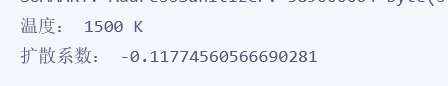

从而确认当前温度下物质为固态。

事实上不能只通过扩散系数来判断，MSD的异常也会导致扩散系数异常。建议检查输出文件中的MSD.dat并绘图。

- 这是正常的MSD
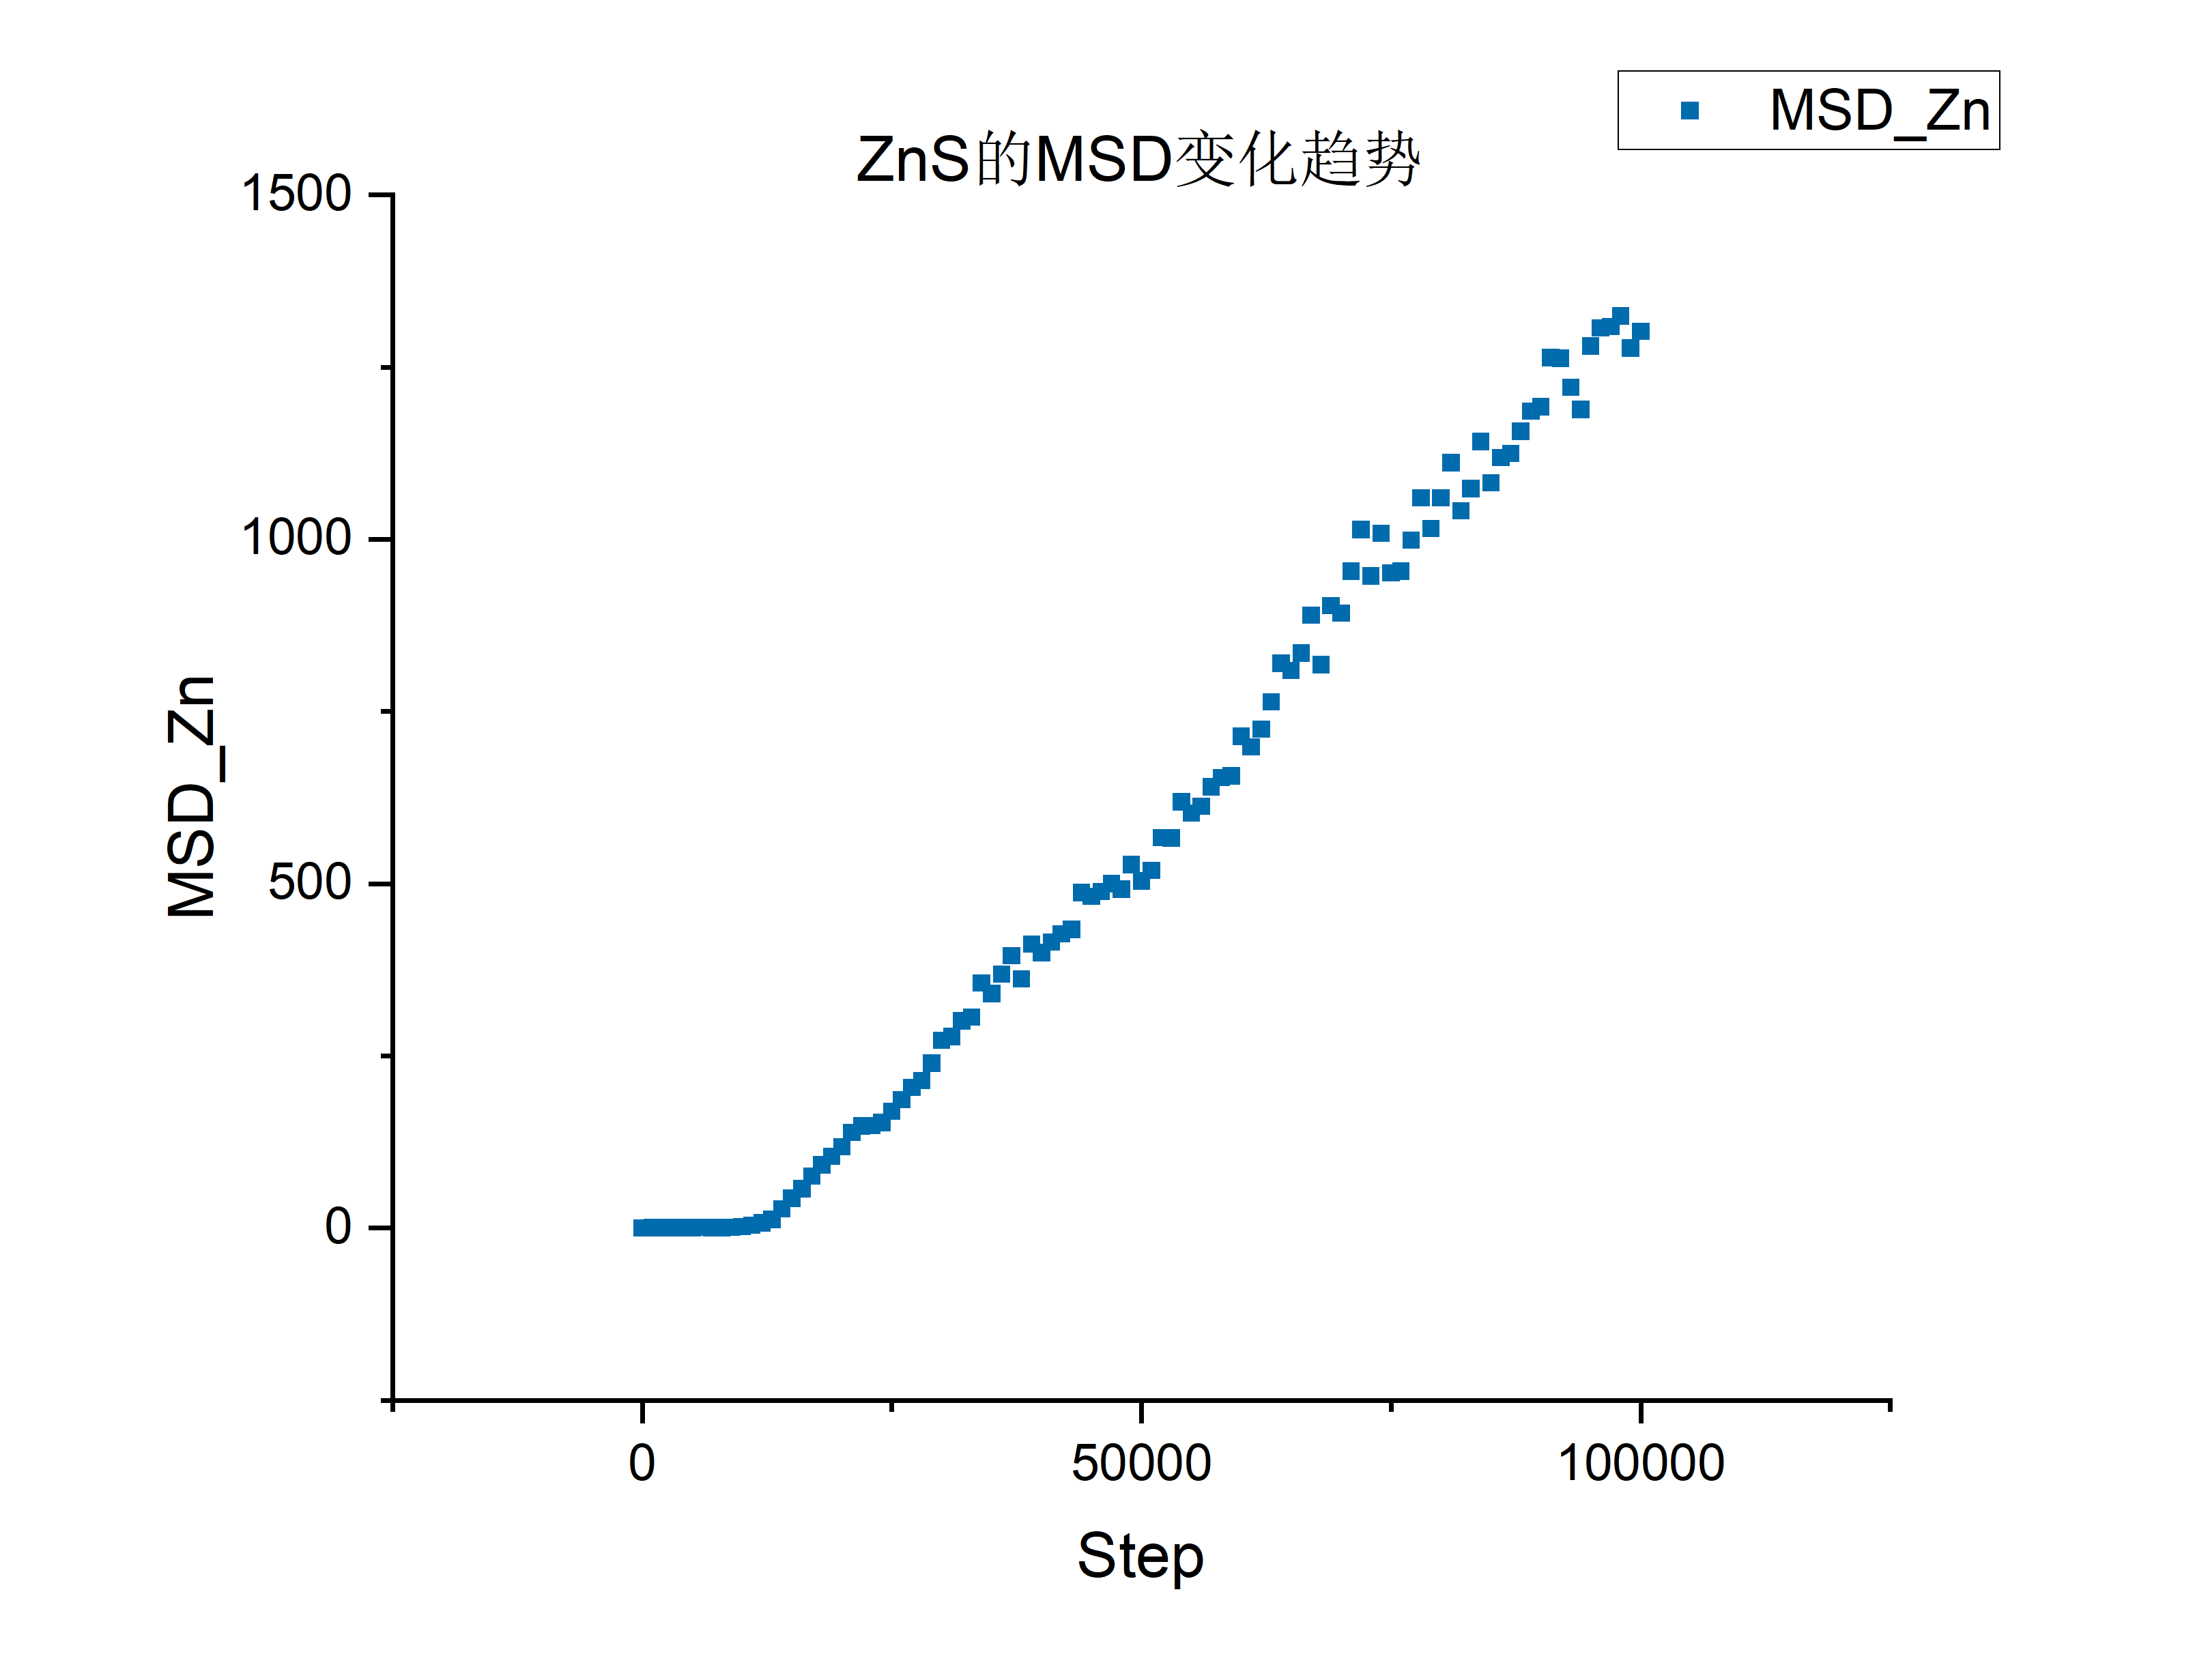
- 这是不正常的MSD
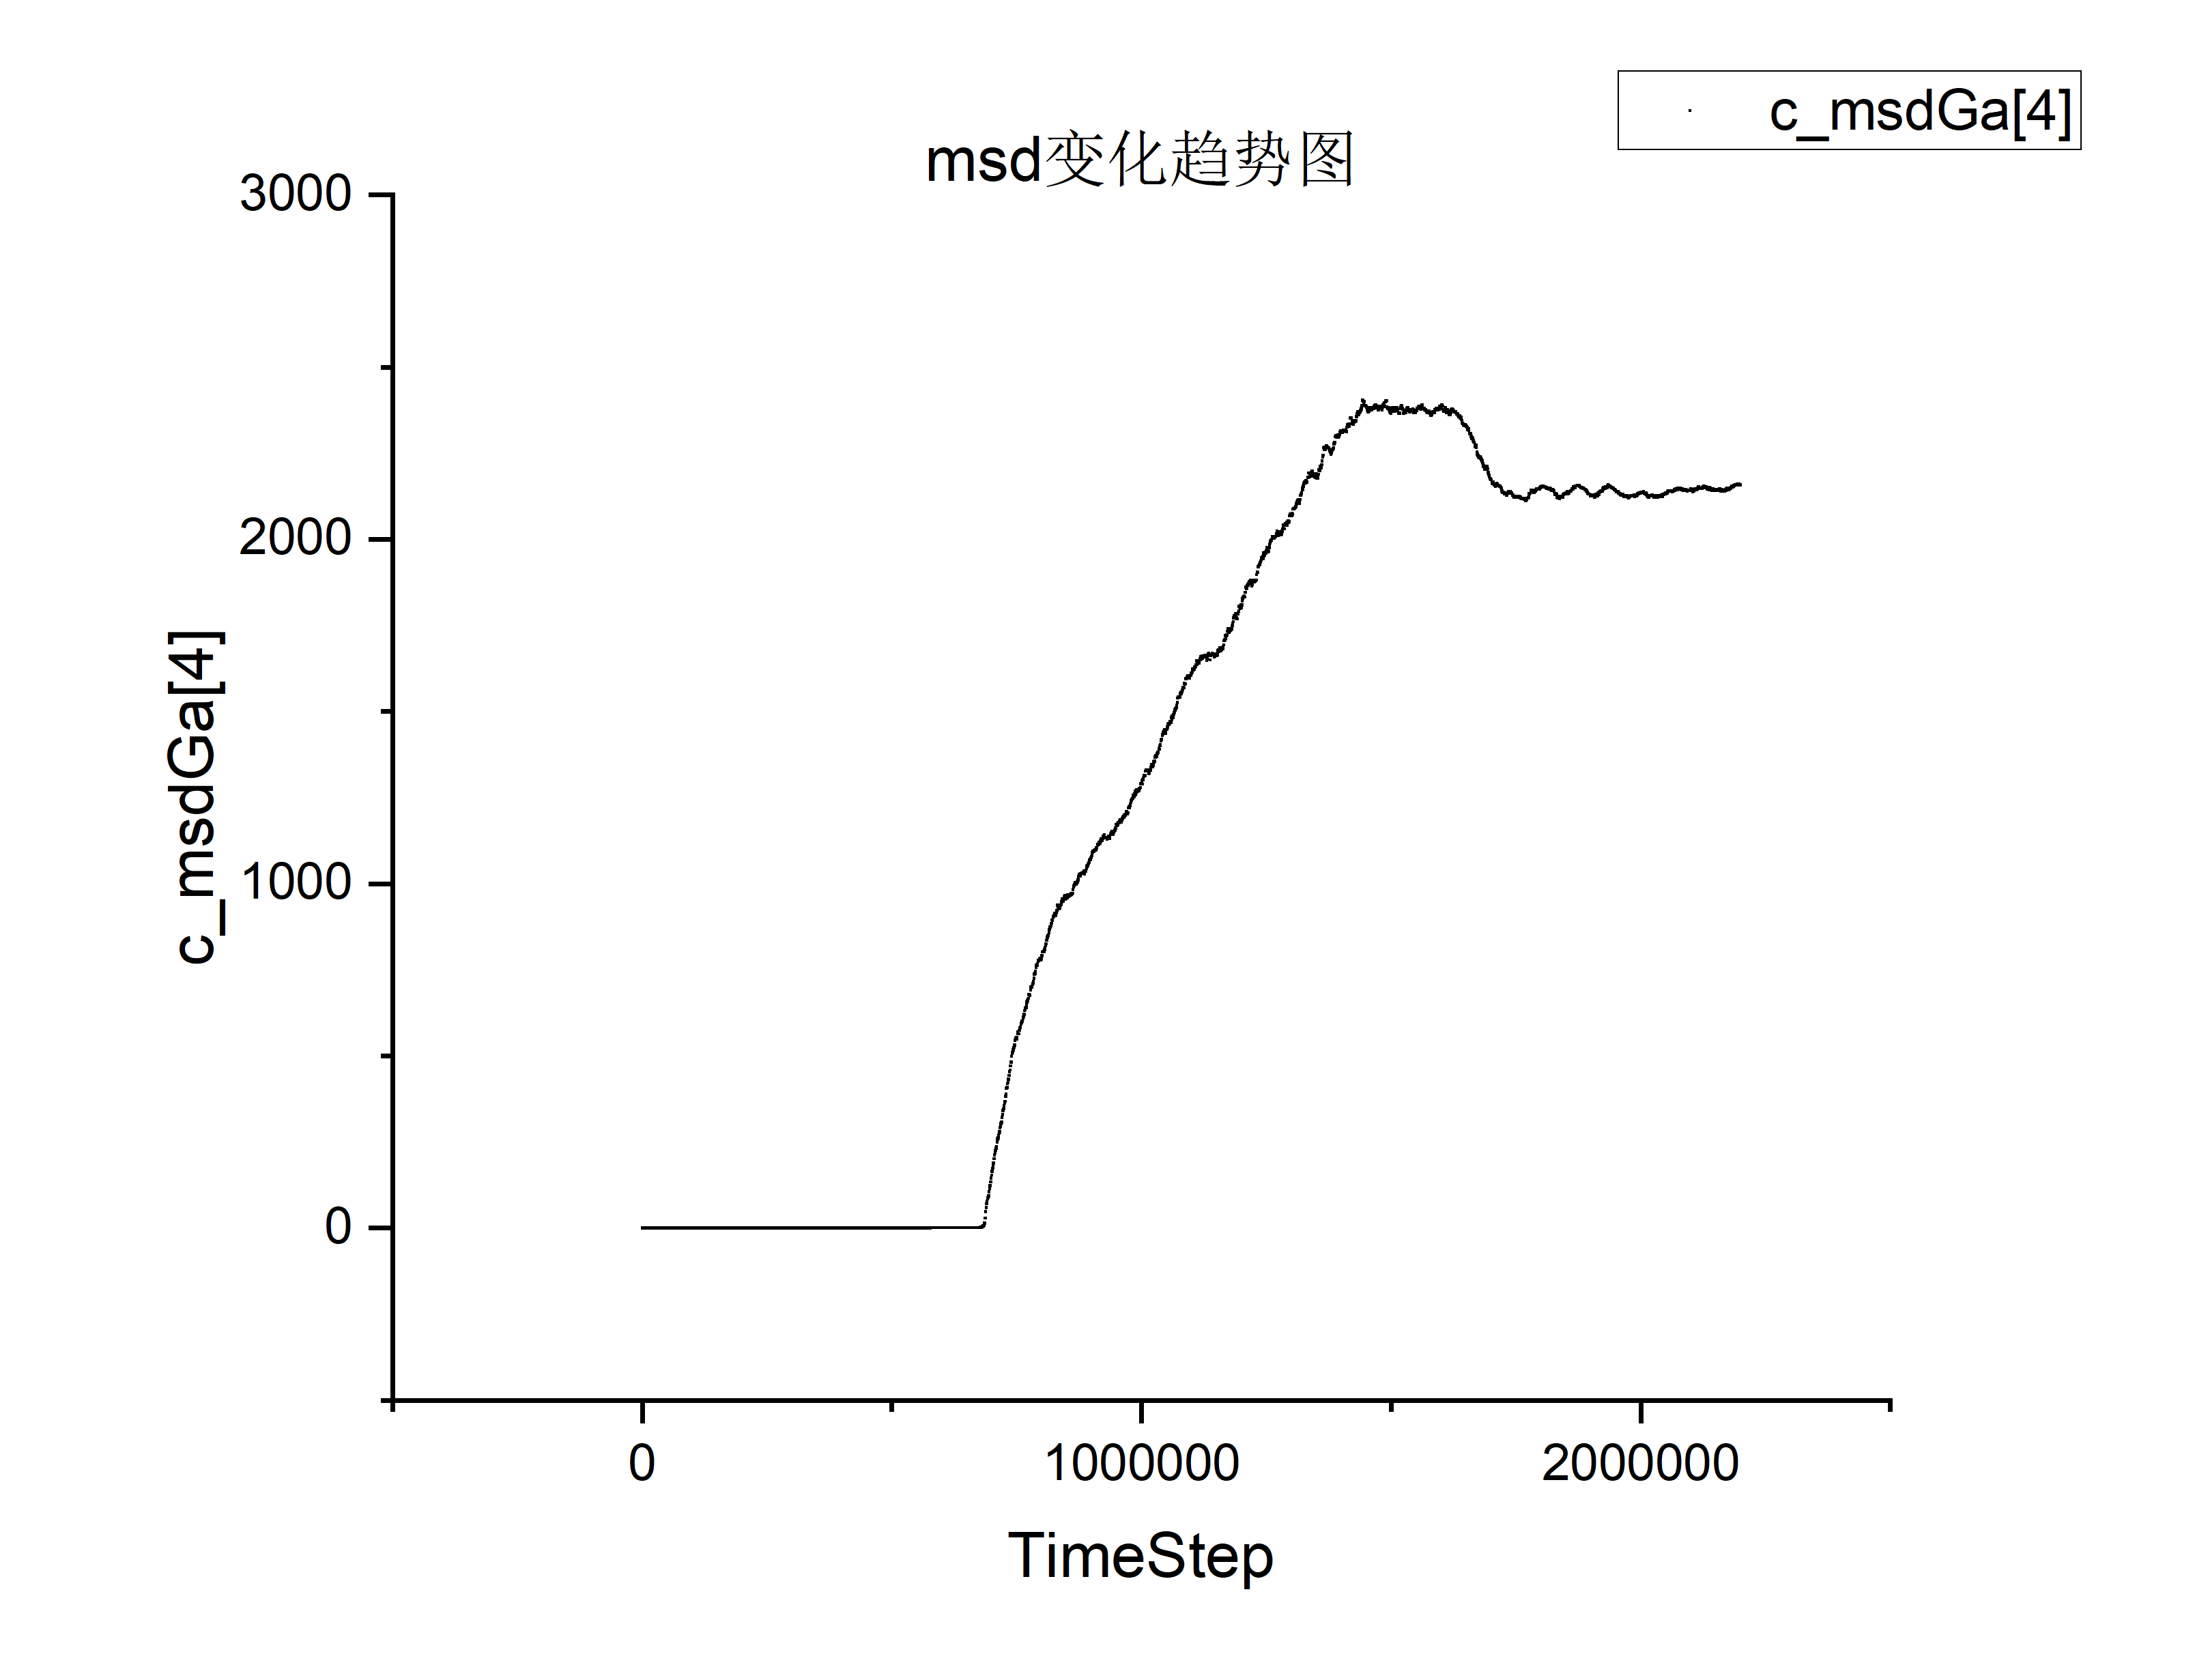

显然不能仅从扩散系数来判断熔点位置是否正常，出现异常情况需要仔细排查。

## 可行的改进方案

- 若不考虑对MSD和扩散系数异常的排查情况，可以将此过程递归化，直至输出的熔点上下界满足精度需求。
- 未来势函数若可以从网站上直接下载，可以实现输入文件准备过程的自动化，无需手动准备输入文件。
- 不只是熔点测试可以用工作流高效实现，对于其他常见的测试性质也可以用工作流来满足测试的工程化需求。

## 参考资料
### ABACUS线上文档
ABACUS中文文档地址：https://mcresearch.gitee.io/abacus-user-guide/
### 熔点计算的文献：
- 直接加热法
- Raty, J. Y., Schwegler, E., & Bonev, S. A. (2008). Electronic and structural transitions in dense liquid sodium. Nature, 451(7175), 676-678.
- Tamblyn, I., Raty, J. Y., & Bonev, S. A. (2008). Tetrahedral Clustering in Molten Lithium under Pressure. Physical Review Letters, 101(7), 075703. doi: 10.1103/PhysRevLett.101.075703.
- 两相法
- Morris, J. R., & Song, X. (2002). The melting lines of model systems calculated from coexistence simulations. Journal of Chemical Physics, 116(21), 9352. doi: 10.1063/1.1474581.Z-method
- Alfe`, D. (2003). First-principles simulations of direct coexistence of solid and liquid aluminum. Physical Review B, 68(6), 064423. doi: 10.1103/PhysRevB.68.064423.
- Herna´ndez, E. R., Rodriguez-Prieto, A., Bergara, A., & Alfe`, D. (2010). First-Principles Simulations of Lithium Melting: Stability of the bcc Phase Close to Melting. Physical Review Letters, 104(17), 175702. doi: 10.1103/PhysRevLett.104.175702.
- Z-method
- Belonoshko, A. B., & Rosengren, A. (2012). High-pressure melting curve of platinum from ab initio Z method. Physical Review B, 85(17), 174104. doi: 10.1103/PhysRevB.85.174104.
- 热力学积分算熔点
- Jesson, B. J., & Maddena, P. A. (2000). Ab initio determination of the melting point of aluminum by thermodynamic integration. Journal of Chemical Physics, 113(5), 1963-1966.
- Vocˇadlo, L., & Alfe`, D. (2002). Ab initio melting curve of the fcc phase of aluminum. Physical Review B, 65(14), 144105.